# Logistic Regression Way #1

In [2]:
from acquire import get_titanic_data
from prepare import  prep_titanic
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import graphviz
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

df = prep_titanic(get_titanic_data())

In [3]:
df.head()

,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,embark_town,alone,embarked_encode
0,0,0,3,male,22.0,1,0,7.2500,S,Third,Southampton,0,3
1,1,1,1,female,38.0,1,0,71.2833,C,First,Cherbourg,0,0
2,2,1,3,female,26.0,0,0,7.9250,S,Third,Southampton,1,3
3,3,1,1,female,35.0,1,0,53.1000,S,First,Southampton,0,3
4,4,0,3,male,35.0,0,0,8.0500,S,Third,Southampton,1,3


In [4]:
df.dropna(inplace=True) # drops all na values

In [5]:
# split the data into test and train
train, test = train_test_split(df, random_state=123) 

# 1. make the thing
scaler = MinMaxScaler()

# 2. fit the thing
scaler.fit(train[['age', 'fare']])

# 3. use the thing
train[['age', 'fare']] = scaler.transform(train[['age', 'fare']])
test[['age', 'fare']] = scaler.transform(test[['age', 'fare']])

In [6]:
train.head()

,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,embark_town,alone,embarked_encode
86,86,0,3,male,0.195778,1,3,0.067096,S,Third,Southampton,0,3
184,184,1,3,female,0.044986,0,2,0.042990,S,Third,Southampton,0,3
406,406,0,3,male,0.635587,0,0,0.015127,S,Third,Southampton,1,3
285,285,0,3,male,0.409399,0,0,0.016908,C,Third,Cherbourg,1,0
591,591,1,1,female,0.648153,1,0,0.152766,C,First,Cherbourg,0,0


In [7]:
logit = LogisticRegression()
logit.fit(train[['pclass','age','fare','sibsp','parch']], train.survived)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [8]:
logit.predict(train[['pclass', 'age', 'fare','sibsp', 'parch']])[:5]

array([1, 1, 0, 0, 1])

In [9]:
train['prediction'] = logit.predict(train[['pclass','age','fare','sibsp','parch']])

In [10]:
(train.survived == train.prediction).sum() / train.shape[0]

0.708411214953271

In [11]:
logit.score(train[['pclass','age','fare','sibsp','parch']], train.survived)

0.708411214953271

In [12]:
# Estimate whether or not a passenger would survive, using the training data
y_pred = logit.predict(train[['pclass','age','fare','sibsp','parch']])

y_pred[:5]

array([1, 1, 0, 0, 1])

In [13]:
# Estimate the probability of a passenger surviving, using the training data
y_pred_proba = logit.predict_proba(train[['pclass','age','fare','sibsp','parch']])
y_pred_proba[:5]


array([[0.49709834, 0.50290166],
       [0.48355872, 0.51644128],
       [0.84203646, 0.15796354],
       [0.78908364, 0.21091636],
       [0.47242887, 0.52757113]])

In [14]:
from sklearn.metrics import confusion_matrix

confusion_matrix(train.survived, train.prediction)

array([[263,  53],
       [103, 116]])

In [15]:
import pandas as pd

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
# Thus in binary classification, the count of true negatives is C 0,0,
# false negatives is 1, 0, true positives is 1, 1 and false positives is 0, 1.

cm = pd.DataFrame(confusion_matrix(train.survived, train.prediction),
             columns=['Pred -', 'Pred +'], index=['Actual -', 'Actual +'])

cm

,Pred -,Pred +
Actual -,263,53
Actual +,103,116


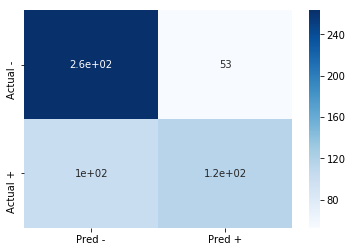

In [16]:
%matplotlib inline
import seaborn as sns

sns.heatmap(cm, cmap='Blues', annot=True)

In [17]:
from sklearn.metrics import classification_report

print(classification_report(train.survived, train.prediction))

              precision    recall  f1-score   support

           0       0.72      0.83      0.77       316
           1       0.69      0.53      0.60       219

   micro avg       0.71      0.71      0.71       535
   macro avg       0.70      0.68      0.68       535
weighted avg       0.71      0.71      0.70       535



In [18]:
train.survived.value_counts()

0    316
1    219
Name: survived, dtype: int64

In [19]:
train.prediction.value_counts()

0    366
1    169
Name: prediction, dtype: int64

In [20]:
print('Accuracy of Logistic Regression classifier on test set: {:.2f}'
    .format(logit.score(test[['pclass', 'age', 'fare', 'sibsp', 'parch']], test.survived)))

Accuracy of Logistic Regression classifier on test set: 0.69


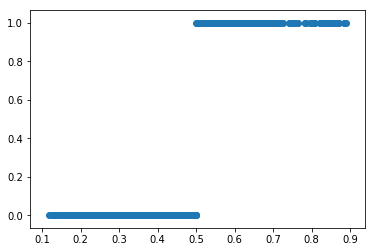

In [21]:
y_pred_proba = [i[1] for i in y_pred_proba]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(y_pred_proba, y_pred)

## Look in the scikit-learn documentation to research the solver parameter. What is your best option(s) for the particular problem you are trying to solve and the data to be used?

In [22]:
# I tried the following for the solver options:
# saga: .69
# sag: .69
# lbfgs: .69
# newton-cg: .69
# default(liblinear): .70

# Looking at these, the default, liblinear, is the best because the predicitive rate was 1% higher than the others

# Logistic Regression Way #2 

In [23]:
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

from acquire import get_titanic_data
from prepare import prep_titanic

df = prep_titanic(get_titanic_data())
df.head()

,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,embark_town,alone,embarked_encode
0,0,0,3,male,22.0,1,0,7.2500,S,Third,Southampton,0,3
1,1,1,1,female,38.0,1,0,71.2833,C,First,Cherbourg,0,0
2,2,1,3,female,26.0,0,0,7.9250,S,Third,Southampton,1,3
3,3,1,1,female,35.0,1,0,53.1000,S,First,Southampton,0,3
4,4,0,3,male,35.0,0,0,8.0500,S,Third,Southampton,1,3


In [24]:
df.dropna(inplace=True)

In [25]:
X = df[['pclass','age','fare', 'sibsp', 'parch']]
y = df[['survived']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=123)

X_train.head()

,pclass,age,fare,sibsp,parch
60,3,22.0,7.2292,0,0
348,3,3.0,15.9000,1,1
606,3,30.0,7.8958,0,0
195,1,58.0,146.5208,0,0
56,2,21.0,10.5000,0,0


## Train Model

In [26]:
# Create the logistic regression object
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(C=1, class_weight={1:2}, random_state=123)



In [27]:
# Fit the model to the training data
logit.fit(X_train, y_train)

LogisticRegression(C=1, class_weight={1: 2}, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=123, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [28]:
# Print the coefficients and intercept of the model
print('Coefficient: \n', logit.coef_)
print('Intercept: \n', logit.intercept_)

Coefficient: 
 [[-0.87476501 -0.02505375  0.00588046 -0.28755904  0.37926043]]
Intercept: 
 [2.76511655]


In [29]:
# Estimate whether or not a passenger would survive, using the training data

y_pred = logit.predict(X_train)

In [30]:
# Estimate the probability of a passenger surviving, using the training data

y_pred_proba = logit.predict_proba(X_train)

## Evaluate Model

In [31]:
# compute the accuracy
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
      .format(logit.score(X_train, y_train)))

Accuracy of Logistic Regression classifier on training set: 0.70


In [32]:
# Create a confusion matrix
print(confusion_matrix(y_train, y_pred))

[[194  99]
 [ 51 155]]


In [33]:
# Compute precision, recall, F1-score, and support
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.66      0.72       293
           1       0.61      0.75      0.67       206

   micro avg       0.70      0.70      0.70       499
   macro avg       0.70      0.71      0.70       499
weighted avg       0.72      0.70      0.70       499



## Test model

In [34]:
# Compute the accuract of the model when run on the test data
print('Accuracy of Logisic Regression classifier on test set: {:.2f}'
     .format(logit.score(X_test, y_test)))

Accuracy of Logisic Regression classifier on test set: 0.67


## Visualize Model

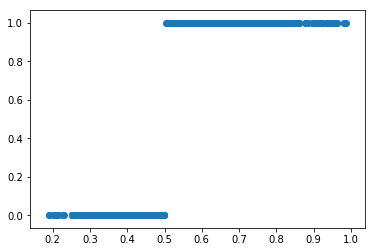

In [35]:
y_pred_proba = [i[1] for i in y_pred_proba]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(y_pred_proba, y_pred)

# Decision Tree for Iris Data

In [36]:
# Fit the decision tree classifier to your training sample and transform (i.e. make predictions 
# on the training sample)
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

import numpy as np

from pydataset import data

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import tree
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

df = data('iris')
df.head()

from acquire import get_iris_data
from prepare import  prep_iris
df = prep_iris(get_iris_data())
df.head()

,species,sepal_length,sepal_width,petal_length,petal_width,species_encode
0,setosa,5.1,3.5,1.4,0.2,0
1,setosa,4.9,3.0,1.4,0.2,0
2,setosa,4.7,3.2,1.3,0.2,0
3,setosa,4.6,3.1,1.5,0.2,0
4,setosa,5.0,3.6,1.4,0.2,0


In [37]:
# training/test split
X = df.drop(['species'], axis=1)
y = df[['species']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state = 123)

X_train.head()

,sepal_length,sepal_width,petal_length,petal_width,species_encode
114,5.8,2.8,5.1,2.4,2
136,6.3,3.4,5.6,2.4,2
53,5.5,2.3,4.0,1.3,1
19,5.1,3.8,1.5,0.3,0
38,4.4,3.0,1.3,0.2,0


## Train Model

In [38]:
# Create the Decision Tree Object
# for classificatiopn you can change the algorithm as gini or entrophy (information gain). Default is gini

clf = DecisionTreeClassifier(criterion = 'entropy', max_depth=3, random_state=123)

In [39]:
# Fit the model to the training data
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=123,
            splitter='best')

In [40]:
# Estimate species
y_pred = clf.predict(X_train)
y_pred[0:5]

array(['virginica', 'virginica', 'versicolor', 'setosa', 'setosa'],
      dtype=object)

In [41]:
# Estimate the probability of a species
y_pred_proba = clf.predict_proba(X_train)
y_pred_proba[:5]

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

## Evaluate Model

In [42]:
# compute the accuracy
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))

Accuracy of Decision Tree classifier on training set: 1.00


In [43]:
# Create a confusion matrix
# True Positive: number of occurrences where y is true and y is predicted true.
# True Negative: number of occurrences where y is false and y is predicted false.
# False Positive: number of occurrences where y is false and y is predicted true.
# False Negative: number of occurrences where y is true and y is predicted false.

confusion_matrix(y_train, y_pred)




array([[32,  0,  0],
       [ 0, 40,  0],
       [ 0,  0, 33]])

In [44]:
sorted(y_train.species.unique())

['setosa', 'versicolor', 'virginica']

In [45]:
y_train.species.value_counts()

versicolor    40
virginica     33
setosa        32
Name: species, dtype: int64

In [46]:
import pandas as pd

In [47]:
labels = sorted(y_train.species.unique())

In [48]:
pd.DataFrame(confusion_matrix(y_train, y_pred), index=labels, columns=labels)

,setosa,versicolor,virginica
setosa,32,0,0
versicolor,0,40,0
virginica,0,0,33


In [49]:
# Create a classification report
# Precision: the higher this number is, the more you were able to pinpoint all positives correctly. If this is a low score, you predicted a lot of positives where there were none. tp / (tp + fp)
# Recall: if this score is high, you didn’t miss a lot of positives. But as it gets lower, you are not predicting the positives that are actually there. tp / (tp + fn)
# f1-score: The balanced harmonic mean of Recall and Precision, giving both metrics equal weight. The higher the F-Measure is, the better.
# Support: number of occurrences of each class in where y is true.


print(classification_report(y_train, y_pred))




              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        32
  versicolor       1.00      1.00      1.00        40
   virginica       1.00      1.00      1.00        33

   micro avg       1.00      1.00      1.00       105
   macro avg       1.00      1.00      1.00       105
weighted avg       1.00      1.00      1.00       105



## Test model

In [50]:
# Compute the accuracy of the model when run on the test data
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Accuracy of Decision Tree classifier on test set: 1.00


In [51]:
from sklearn.datasets import load_iris

iris = load_iris()
clf = tree.DecisionTreeClassifier()
clf = clf.fit(iris.data, iris.target)

In [52]:
import graphviz
from graphviz import Graph

In [53]:
dot_data = tree.export_graphviz(clf, out_file=None)
graph = graphviz.Source(dot_data)

graph.render('iris_decision_tree2', view=True)

'iris_decision_tree2.pdf'

# Decision Tree for Titanic Data

In [54]:
# Fit the decision tree classifier to your training sample and transform (i.e. make predictions 
# on the training sample)
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

import numpy as np

from pydataset import data

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import tree
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from acquire import get_titanic_data
from prepare import  prep_titanic
df = prep_titanic(get_titanic_data())
df.head()

,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,embark_town,alone,embarked_encode
0,0,0,3,male,22.0,1,0,7.2500,S,Third,Southampton,0,3
1,1,1,1,female,38.0,1,0,71.2833,C,First,Cherbourg,0,0
2,2,1,3,female,26.0,0,0,7.9250,S,Third,Southampton,1,3
3,3,1,1,female,35.0,1,0,53.1000,S,First,Southampton,0,3
4,4,0,3,male,35.0,0,0,8.0500,S,Third,Southampton,1,3


In [55]:
# training/test split
X = df[['pclass','fare', 'sibsp', 'parch']]
y = df[['survived']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=123)

X_train.isna().sum()

pclass    0
fare      0
sibsp     0
parch     0
dtype: int64

In [56]:
# Create the Decision Tree Object
# for classificatiopn you can change the algorithm as gini or entrophy (information gain). Default is gini

clf = DecisionTreeClassifier(criterion = 'gini', max_depth=6, random_state=123)

In [57]:
# Fit the model to the training data
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=123,
            splitter='best')

In [58]:
# Estimate species
y_pred = clf.predict(X_train)
y_pred[0:5]

array([1, 1, 0, 0, 0])

In [59]:
# Estimate the probability of a species
y_pred_proba = clf.predict_proba(X_train)
y_pred_proba[:5]

array([[0.21052632, 0.78947368],
       [0.21052632, 0.78947368],
       [0.52873563, 0.47126437],
       [0.96296296, 0.03703704],
       [0.66666667, 0.33333333]])

In [60]:
# compute the accuracy
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.73


In [61]:
# Create a confusion matrix
# True Positive: number of occurrences where y is true and y is predicted true.
# True Negative: number of occurrences where y is false and y is predicted false.
# False Positive: number of occurrences where y is false and y is predicted true.
# False Negative: number of occurrences where y is true and y is predicted false.

confusion_matrix(y_train, y_pred)

array([[353,  26],
       [140, 104]])

In [62]:
# Compute the accuracy of the model when run on the test data
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Accuracy of Decision Tree classifier on test set: 0.76


In [63]:
from sklearn.datasets import load_iris

iris = load_iris()
clf = tree.DecisionTreeClassifier()
clf = clf.fit(iris.data, iris.target)

In [64]:
import graphviz
from graphviz import Graph

In [65]:
dot_data = tree.export_graphviz(clf, out_file=None)
graph = graphviz.Source(dot_data)

graph.render('iris_decision_tree2', view=True)

'iris_decision_tree2.pdf'

# K-N N for Titanic Data

In [118]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from acquire import get_titanic_data
from prepare import prep_titanic

df = prep_titanic(get_titanic_data())

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
passenger_id       891 non-null int64
survived           891 non-null int64
pclass             891 non-null int64
sex                891 non-null object
age                714 non-null float64
sibsp              891 non-null int64
parch              891 non-null int64
fare               891 non-null float64
embarked           891 non-null object
class              891 non-null object
embark_town        891 non-null object
alone              891 non-null int64
embarked_encode    891 non-null int64
dtypes: float64(2), int64(7), object(4)
memory usage: 90.6+ KB


In [119]:
df.dropna(inplace=True) # handles missing age vaules

X = df[['pclass', 'age', 'fare', 'sibsp', 'parch']]
y = df[['survived']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= .30, random_state = 123)

## Train model

In [137]:
# Create KNN object
# weights = ['uniform', 'density']
knn_fit = KNeighborsClassifier(n_neighbors=5, weights='uniform')

In [138]:
# Fit the model to the training data
knn_fit.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [139]:
# Estimate whether or not a passenger would survive, using the training data

y_pred = knn_fit.predict(X_train)

In [140]:
# Estimate the probablility of a passenger surviving, using the training data

y_pred_proba = knn_fit.predict_proba(X_train)

## Evaluate model

In [141]:
# Compute the accuracy
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn_fit.score(X_train, y_train)))

Accuracy of KNN classifier on training set: 0.76


In [142]:
# Create a confusin matrix
print(confusion_matrix(y_train, y_pred))

[[239  54]
 [ 65 141]]


In [143]:
# Compute precision, recall, f1-score, and support
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.82      0.80       293
           1       0.72      0.68      0.70       206

   micro avg       0.76      0.76      0.76       499
   macro avg       0.75      0.75      0.75       499
weighted avg       0.76      0.76      0.76       499



## Test model

In [144]:
# Compute the accuracy of the model when run on the test data
print('Accuracy of KNN classifier on test set: {:.2f}'
     .format(knn_fit.score(X_test, y_test)))

Accuracy of KNN classifier on test set: 0.67


## Visualize model

([<matplotlib.axis.XTick at 0x1a1dbf28d0>,
 <a list of 5 Text xticklabel objects>)

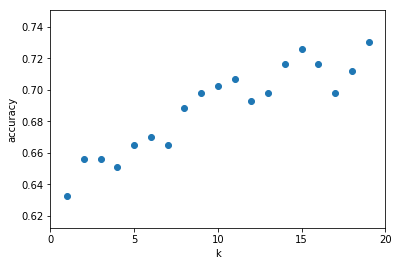

In [145]:
import matplotlib.pyplot as plt
k_range = range(1, 20)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20])

# K-N N for Iris Data

In [77]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from acquire import get_iris_data
from prepare import prep_iris

df = prep_iris(get_iris_data())

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
species           150 non-null object
sepal_length      150 non-null float64
sepal_width       150 non-null float64
petal_length      150 non-null float64
petal_width       150 non-null float64
species_encode    150 non-null int64
dtypes: float64(4), int64(1), object(1)
memory usage: 7.1+ KB


In [78]:
X = df.drop(['species'], axis= 1)
y = df[['species']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=123)

X_train.head()

,sepal_length,sepal_width,petal_length,petal_width,species_encode
114,5.8,2.8,5.1,2.4,2
136,6.3,3.4,5.6,2.4,2
53,5.5,2.3,4.0,1.3,1
19,5.1,3.8,1.5,0.3,0
38,4.4,3.0,1.3,0.2,0


## Train model

In [146]:
# Create KNN object
knn_fit = KNeighborsClassifier(n_neighbors=5, weights='uniform')

In [147]:
knn_fit.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [148]:
# Estimate the species using the training data

y_pred = knn_fit.predict(X_train)


In [149]:
# Estimate the probability of a species, using the training data

y_pred_proba = knn_fit.predict_proba(X_train)

## Evaluate model 

In [150]:
# Compute the accuracy
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn_fit.score(X_train, y_train)))

Accuracy of KNN classifier on training set: 0.76


In [151]:
# Create a confusion matrix
print(confusion_matrix(y_train,y_pred))

[[239  54]
 [ 65 141]]


In [152]:
# Compute precision, recall, f1-score and support
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.82      0.80       293
           1       0.72      0.68      0.70       206

   micro avg       0.76      0.76      0.76       499
   macro avg       0.75      0.75      0.75       499
weighted avg       0.76      0.76      0.76       499



## Test model

In [153]:
# Compute the accuracy of the model when run on the test data
print('Accuracy of KNN classifier on test set: {:.2f}'
     .format(knn_fit.score(X_test, y_test)))

Accuracy of KNN classifier on test set: 0.67


## Visualize model

([<matplotlib.axis.XTick at 0x1a1de1b400>,
 <a list of 5 Text xticklabel objects>)

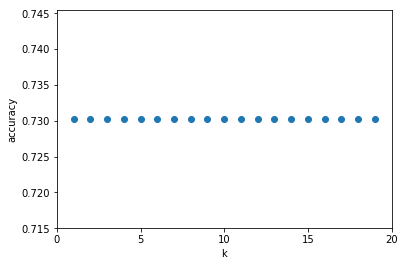

In [154]:
import matplotlib.pyplot as plt
k_range = range(1, 20)
scores = []
for k in k_range:
    knn_fit = KNeighborsClassifier(n_neighbors = k)
    knn_fit.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20])

# Random Forest for Titanic Data

In [88]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from acquire import get_titanic_data
from prepare import prep_titanic

df = prep_titanic(get_titanic_data())
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
passenger_id       891 non-null int64
survived           891 non-null int64
pclass             891 non-null int64
sex                891 non-null object
age                714 non-null float64
sibsp              891 non-null int64
parch              891 non-null int64
fare               891 non-null float64
embarked           891 non-null object
class              891 non-null object
embark_town        891 non-null object
alone              891 non-null int64
embarked_encode    891 non-null int64
dtypes: float64(2), int64(7), object(4)
memory usage: 90.6+ KB


In [89]:
# Handle missing age values
df.dropna(inplace=True)

X = df[['pclass', 'age', 'fare', 'sibsp', 'parch']]
y = df.survived

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=123)

X_train.head()


,pclass,age,fare,sibsp,parch
60,3,22.0,7.2292,0,0
348,3,3.0,15.9000,1,1
606,3,30.0,7.8958,0,0
195,1,58.0,146.5208,0,0
56,2,21.0,10.5000,0,0


## Train model

In [90]:
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=3, 
                            random_state=123)

In [91]:
# Fit the model to the training data
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=123, verbose=0, warm_start=False)

In [92]:
# Print Feature importances
print(rf.feature_importances_)

[0.32480013 0.13752631 0.37630011 0.07262912 0.08874434]


In [93]:
# Estimate whether or not a passenger would survive, using the training data

y_pred = rf.predict(X_train)

In [94]:
# Estimate the prabability of a passenger surviving, using the training data

y_pred_proba = rf.predict_proba(X_train)

## Evaluate model

In [95]:
# Compute the accurancy
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_train, y_train)))

Accuracy of random forest classifier on training set: 0.75


In [96]:
# Create a confusion matrix
print(confusion_matrix(y_train, y_pred))

[[248  45]
 [ 79 127]]


In [97]:
# Create a classification report
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.85      0.80       293
           1       0.74      0.62      0.67       206

   micro avg       0.75      0.75      0.75       499
   macro avg       0.75      0.73      0.74       499
weighted avg       0.75      0.75      0.75       499



## Test model

In [98]:
# Compute the accuract of the model when run on the test data
print('Accuracy of random forest classifier on test set: {:.2f}'
     .format(rf.score(X_test, y_test)))

Accuracy of random forest classifier on test set: 0.74


# Random Forest for Iris Data

In [99]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from acquire import get_iris_data
from prepare import prep_iris

df = prep_iris(get_iris_data())
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
species           150 non-null object
sepal_length      150 non-null float64
sepal_width       150 non-null float64
petal_length      150 non-null float64
petal_width       150 non-null float64
species_encode    150 non-null int64
dtypes: float64(4), int64(1), object(1)
memory usage: 7.1+ KB


In [100]:
X = df.drop(['species'], axis=1)
y = df[['species']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state = 123)

X_train.head()

,sepal_length,sepal_width,petal_length,petal_width,species_encode
114,5.8,2.8,5.1,2.4,2
136,6.3,3.4,5.6,2.4,2
53,5.5,2.3,4.0,1.3,1
19,5.1,3.8,1.5,0.3,0
38,4.4,3.0,1.3,0.2,0


## Train model

In [101]:
# Create the random forest object
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=3, 
                            random_state=123)

In [102]:
# Fit the model to the training data
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=123, verbose=0, warm_start=False)

In [103]:
# Print feature importances
print(rf.feature_importances_)

[0.05335338 0.00273967 0.2991058  0.2599854  0.38481576]


In [104]:
# Estimate whether or not a passenger would survive, using the training data

y_pred = rf.predict(X_train)

In [105]:
# Estimate the probability of a passenger surviving, using the training data

y_pred_proba = rf.predict_proba(X_train)

## Evaluate Model

In [106]:
# Compute the accuracy
print(print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_train, y_train))))

Accuracy of random forest classifier on training set: 1.00
None


In [107]:
# Create a confusion matrix
print(confusion_matrix(y_train, y_pred))

[[32  0  0]
 [ 0 40  0]
 [ 0  0 33]]


In [108]:
# Create a classification report
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        32
  versicolor       1.00      1.00      1.00        40
   virginica       1.00      1.00      1.00        33

   micro avg       1.00      1.00      1.00       105
   macro avg       1.00      1.00      1.00       105
weighted avg       1.00      1.00      1.00       105



## Test model

In [109]:
# Compute the accuracy of the model when run on the test data
print('Accuracy of random forest classifier on test set: {:.2f}'
     .format(rf.score(X_test, y_test)))

Accuracy of random forest classifier on test set: 1.00
